## TPE Tuning

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

In [29]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_P")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,64.585900,0,27.0,0.377501,128.715226,0.422342,115.630163,15.181458,333.805425,...,286.270009,0.289728,206.373786,44.577974,539.225137,3.320292,22924.739100,3.3445,2251,7338.2
1,0,68.076660,2,20.0,0.657212,51.830551,0.557254,84.225204,8.530596,285.070266,...,282.873623,0.310507,206.276556,39.697933,542.232602,2.864138,18182.687670,2.9605,2924,5438.6
2,1,76.221760,1,28.0,0.520032,86.558742,0.594543,123.662642,13.400504,408.091827,...,244.274039,0.370189,201.216707,46.081559,560.592790,3.415186,28045.350990,3.3145,4042,8434.4
3,0,73.221085,0,30.0,0.396133,60.731686,0.596733,122.546512,15.571183,429.454361,...,226.713342,0.517430,232.983710,30.461877,705.221498,2.937422,1196.160472,3.1505,3485,7476.2
4,0,45.872690,0,30.0,0.404800,108.808540,0.520363,98.065558,13.483247,283.453692,...,202.074647,0.354851,169.528802,50.680275,476.040561,3.017047,47743.254120,3.5420,3964,8021.8


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((508, 22), (219, 22))

In [31]:
imputer_knn = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [32]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [33]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [34]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((508, 22), (219, 22))

In [ ]:
sel = ['Gender', 'Age', 'MMSE', 'Hip ASM', 'Hip Contrast', 'Hip Correlation',
       'Hip Variance ', 'Hip Sum Average', 'Hip Sum Variance', 'Hip Entropy',
       'Hip Clusterhade', 'ERC ASM', 'ERC CONTRAST', 'ERC CORRELATION',
       'ERC VARIANCE ', 'ERC SUM VARIANCE', 'ERC ENTROPY', 'ERC CLUSTER SHADE',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME']

In [36]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Gender',
 'Age',
 'MMSE',
 'Hip ASM',
 'Hip Contrast',
 'Hip Correlation',
 'Hip Variance ',
 'Hip Sum Average',
 'Hip Sum Variance',
 'Hip Entropy',
 'Hip Clusterhade',
 'ERC ASM',
 'ERC CONTRAST',
 'ERC CORRELATION',
 'ERC VARIANCE ',
 'ERC SUM VARIANCE',
 'ERC ENTROPY',
 'ERC CLUSTER SHADE',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [37]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((508, 21), (219, 21))

## TPE

In [38]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
            
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 500)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 5)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2)
    xgb_subsample = trial.suggest_float("xgb_subsample", 0.5, 1.0)
    xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0)
    xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 6)
    xgb_gamma = trial.suggest_float("xgb_gamma", 0.0, 2.0)

    model = XGBClassifier(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        subsample=xgb_subsample,
        colsample_bytree=xgb_colsample_bytree,
        min_child_weight=xgb_min_child_weight,
        gamma=xgb_gamma,
        objective="multi:softprob",
        num_class=len(set(y_train))
    )

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [39]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-08-04 21:46:11,490] A new study created in memory with name: no-name-934a1e0a-57b3-4125-9e9b-67ee72b7eb34


[I 2025-08-04 21:46:41,655] Trial 0 finished with value: 0.5556835064729801 and parameters: {'xgb_n_estimators': 307, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.12003587228576781, 'xgb_subsample': 0.5763935273503815, 'xgb_colsample_bytree': 0.8805391802182789, 'xgb_min_child_weight': 3, 'xgb_gamma': 1.858793925434792}. Best is trial 0 with value: 0.5556835064729801.
[I 2025-08-04 21:47:15,121] Trial 1 finished with value: 0.5395396353291091 and parameters: {'xgb_n_estimators': 456, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.036833731519174726, 'xgb_subsample': 0.577339556996504, 'xgb_colsample_bytree': 0.8833919852041843, 'xgb_min_child_weight': 4, 'xgb_gamma': 1.987950756706978}. Best is trial 0 with value: 0.5556835064729801.
[I 2025-08-04 21:47:35,063] Trial 2 finished with value: 0.556016207595155 and parameters: {'xgb_n_estimators': 428, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.0689669922018639, 'xgb_subsample': 0.6857469578869926, 'xgb_colsample_bytree': 0.6475394202040509, 'xg

In [40]:
study.best_params

{'xgb_n_estimators': 495,
 'xgb_max_depth': 5,
 'xgb_learning_rate': 0.12516873210972193,
 'xgb_subsample': 0.7293408105987877,
 'xgb_colsample_bytree': 0.959741519604856,
 'xgb_min_child_weight': 3,
 'xgb_gamma': 0.3539507379036535}

In [41]:
study.best_value

0.5578180093969568

In [42]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_xgb_colsample_bytree,params_xgb_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_min_child_weight,params_xgb_n_estimators,params_xgb_subsample,state
0,0,0.555684,2025-08-04 21:46:11.524414,2025-08-04 21:46:41.652380,0 days 00:00:30.127966,0.880539,1.858794,0.120036,5,3,307,0.576394,COMPLETE
1,1,0.539540,2025-08-04 21:46:41.664617,2025-08-04 21:47:15.121069,0 days 00:00:33.456452,0.883392,1.987951,0.036834,2,4,456,0.577340,COMPLETE
2,2,0.556016,2025-08-04 21:47:15.123169,2025-08-04 21:47:35.059456,0 days 00:00:19.936287,0.647539,0.586172,0.068967,2,4,428,0.685747,COMPLETE
3,3,0.534437,2025-08-04 21:47:35.065585,2025-08-04 21:47:44.116802,0 days 00:00:09.051217,0.792705,1.839310,0.129499,4,5,174,0.597108,COMPLETE
4,4,0.543001,2025-08-04 21:47:44.119804,2025-08-04 21:48:04.024304,0 days 00:00:19.904500,0.842157,0.804314,0.090643,2,1,397,0.728371,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_19484\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


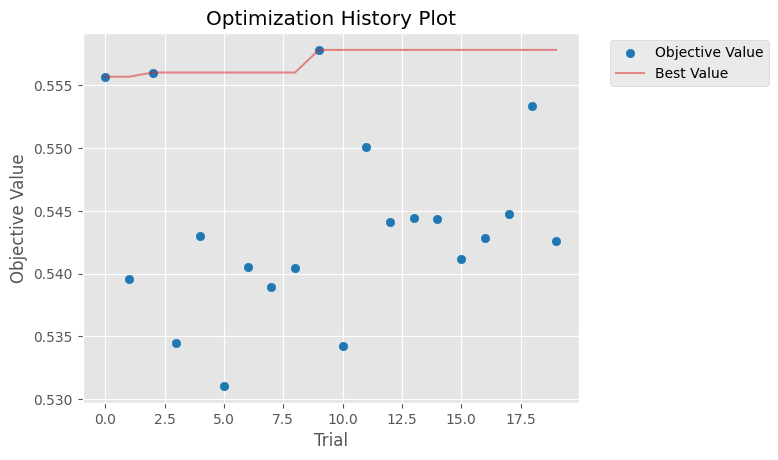

In [43]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_19484\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

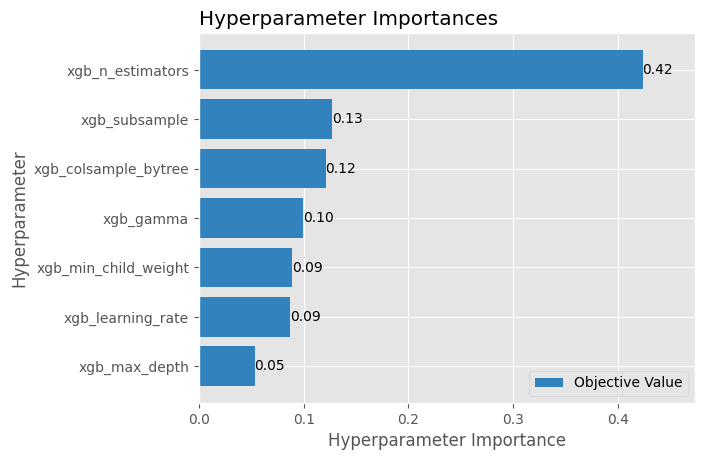

In [44]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_19484\1403512554.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='xgb_colsample_bytree', ylabel='Objective Value'>,
       <Axes: xlabel='xgb_gamma'>, <Axes: xlabel='xgb_learning_rate'>,
       <Axes: xlabel='xgb_max_depth'>,
       <Axes: xlabel='xgb_min_child_weight'>,
       <Axes: xlabel='xgb_n_estimators'>, <Axes: xlabel='xgb_subsample'>],
      dtype=object)

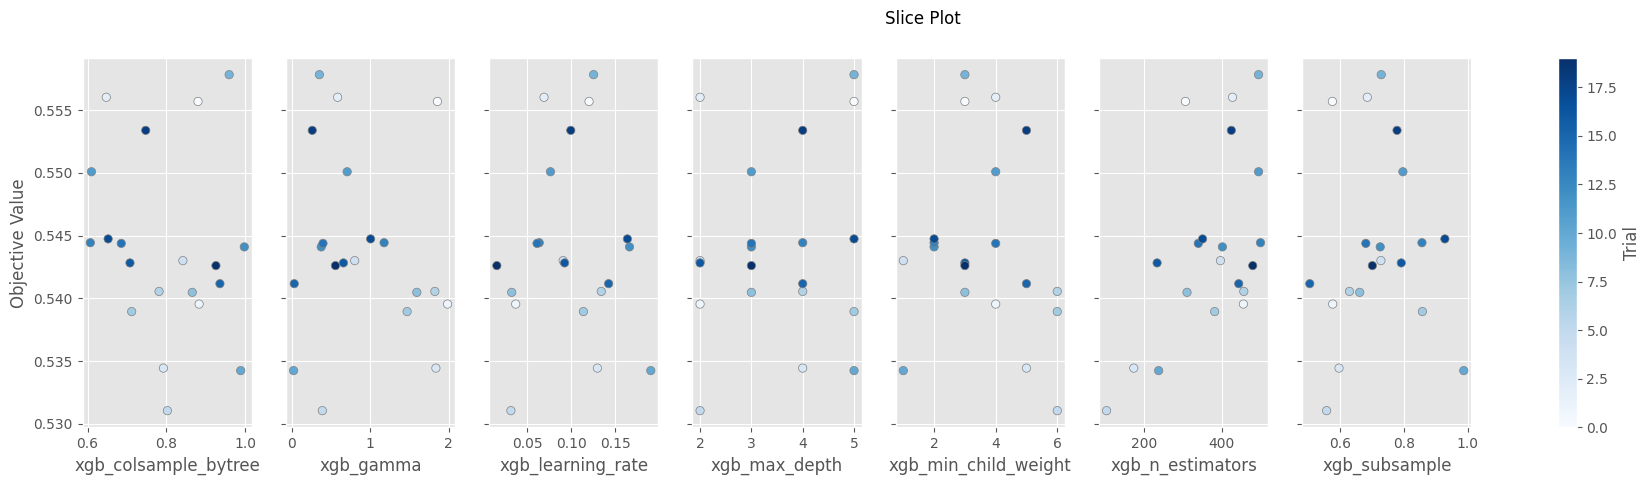

In [45]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["xgb_n_estimators", "xgb_max_depth", "xgb_learning_rate", 
            'xgb_subsample', 'xgb_colsample_bytree', 'xgb_min_child_weight',
            'xgb_gamma'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_19484\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

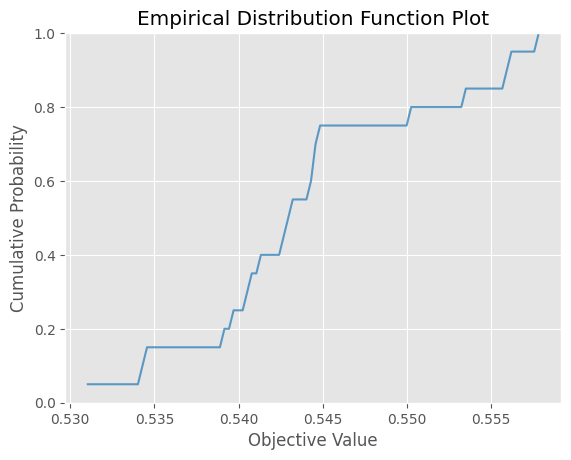

In [46]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [47]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = XGBClassifier(
                n_estimators=study.best_params["xgb_n_estimators"],
                max_depth=study.best_params["xgb_max_depth"],
                learning_rate=study.best_params["xgb_learning_rate"],
                subsample=study.best_params["xgb_subsample"],
                colsample_bytree=study.best_params["xgb_colsample_bytree"],
                min_child_weight=study.best_params["xgb_min_child_weight"],
                gamma=study.best_params["xgb_gamma"],
                objective="multi:softprob",
                num_class=len(set(y_train))
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [48]:
trained_xgb_n, metrics_xgb_n = run_model("XGBoost", "Complete", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", "Boruta", X_train_t, y_train)

In [49]:
validation_df = pd.concat([metrics_xgb_n, metrics_xgb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
XGBoost    balanced_accuracy Complete          1.902    22                     1.0   
                             Boruta            1.663    21                     1.0   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          1.902    22                    0.0   
                             Boruta            1.663    21                    0.0   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          1.902    22                  0.558   
                             Boruta            1.663    21                  0.558   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
XGBoost    balanced_accuracy Complete          1.902    22                 0.041  
                             Boruta            1.663    21                 0.042

In [50]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [51]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [52]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Spearman",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [53]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_n, pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                          
Spearman          XGBoost    0.166               22             accuracy                  1.0   
                                                                balanced_accuracy         1.0   
                                                                precision_macro           1.0   
                                                                recall_macro              1.0   
                                                                f1_macro                  1.0   
                                                                roc_auc_macro             1.0   
                                                                specificity_macro         1.0   
                             0.245               21             accuracy                  1.0   
                                                                balanced_accuracy         1.0   
                                                                precision_macro           1.0   
                                                                recall_macro              1.0   
                                                                f1_macro                  1.0   
                                                                roc_auc_macro             1.0   
                                                                specificity_macro         1.0   

                                                                                   Test data  \
Feature Selection Classifier Classification Time Total Features Metric                         
Spearman          XGBoost    0.166               22             accuracy               0.785   
                                                                balanced_accuracy      0.547   
                                                                precision_macro        0.490   
                                                                recall_macro           0.547   
                                                                f1_macro               0.516   
                                                                roc_auc_macro          0.784   
                                                                specificity_macro      0.830   
                             0.245               21             accuracy               0.808   
                                                                balanced_accuracy      0.569   
                                                                precision_macro        0.503   
                                                                recall_macro           0.569   
                                                                f1_macro               0.533   
                                                                roc_auc_macro          0.780   
                                                                specificity_macro      0.846   

                                                                                           95% CI  \
Feature Selection Classifier Classification Time Total Features Metric                              
Spearman          XGBoost    0.166               22             accuracy            [0.74, 0.822]   
                                                                balanced_accuracy  [0.501, 0.592]   
                                                                precision_macro    [0.452, 0.528]   
                                                                recall_macro       [0.501, 0.594]   
                                                                f1_macro           [0.476, 0.553]   
                                                                roc_auc_macro      [0.725, 0.846]   
                                                                specificity_macro  [0.793, 0.865]   
                             0.245               21             accuracy           [

### Export model

In [54]:
trained_xgb_t.save_model("xgboost_model.json")